In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, r2_score, f1_score, accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from matplotlib import pyplot as plt
from modeling import preprocess, train, evaluate, optimize
from itertools import product

np.random.seed(42)

In [2]:
df = pd.read_csv('data/processed/clean_and_filled.csv')

Training models...: 100%|██████████| 4/4 [00:00<00:00, 15.64it/s]


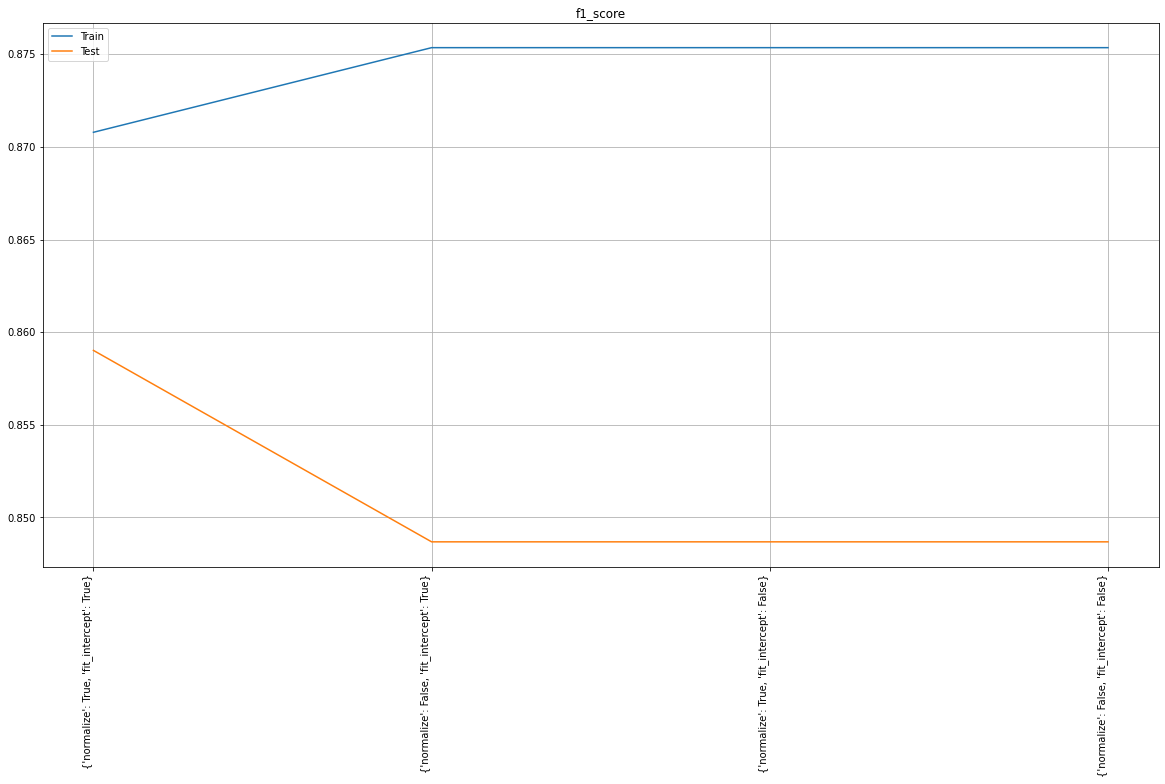

{'f1_score': 0.8590163934426229, 'accuracy_score': 0.8407407407407408, 'precision_score': 0.8291139240506329, 'recall_score': 0.891156462585034}
{'normalize': True, 'fit_intercept': True}


In [3]:
test_size = 0.3
linear_model, linear_res, linear_best_score, linear_best_params = optimize(df, test_size, model_constructor=LinearRegression, param_list=[{'normalize': True, 'fit_intercept': True},
                                                {'normalize': False, 'fit_intercept': True},
                                                {'normalize': True, 'fit_intercept': False},
                                                {'normalize': False, 'fit_intercept': False}])

print(linear_best_score)
print(linear_best_params)

Training models...: 100%|██████████| 100/100 [00:09<00:00, 10.68it/s]


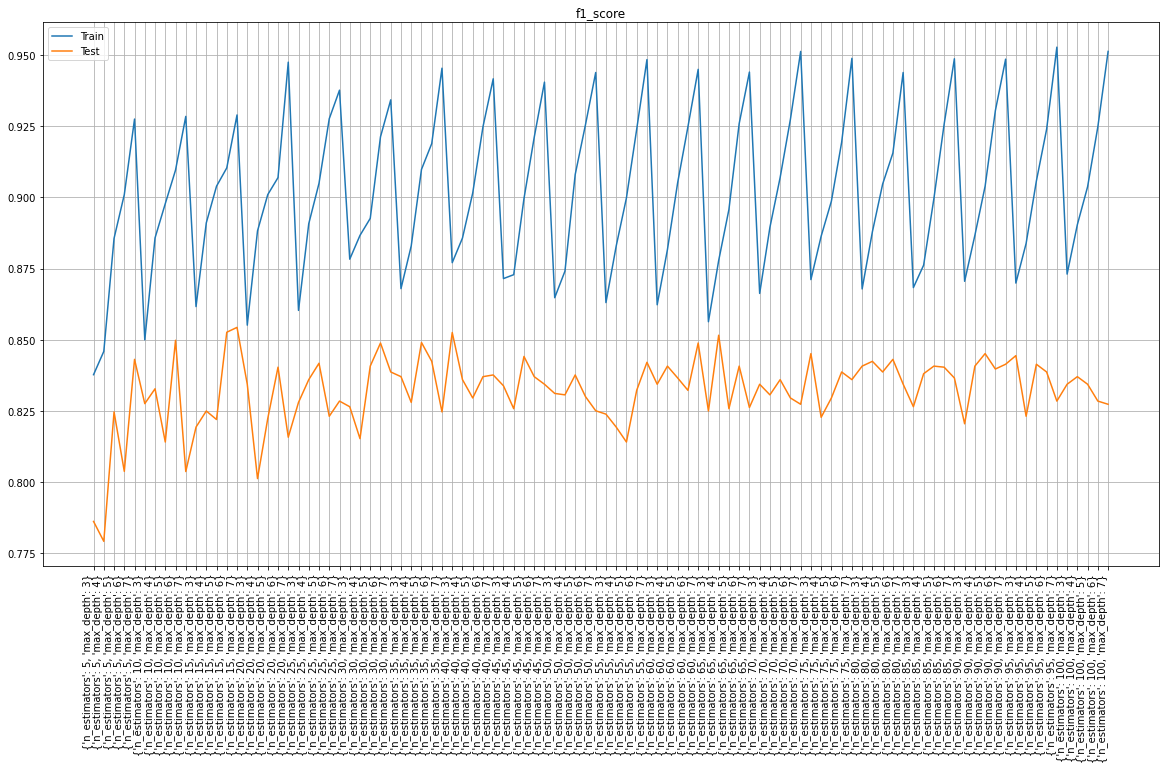

{'f1_score': 0.8543689320388349, 'accuracy_score': 0.8333333333333334, 'precision_score': 0.8407643312101911, 'recall_score': 0.868421052631579}
{'n_estimators': 15, 'max_depth': 7}


In [4]:
rf_params = [{'n_estimators': n, 'max_depth': d} for n, d in product(np.arange(5, 101, 5), np.arange(3, 8))]
rf_model, rf_result, rf_best_score, rf_best_params = optimize(df, test_size, model_constructor=RandomForestClassifier, param_list=rf_params)

print(rf_best_score)
print(rf_best_params)

Training models...: 100%|██████████| 200/200 [01:19<00:00,  2.50it/s]


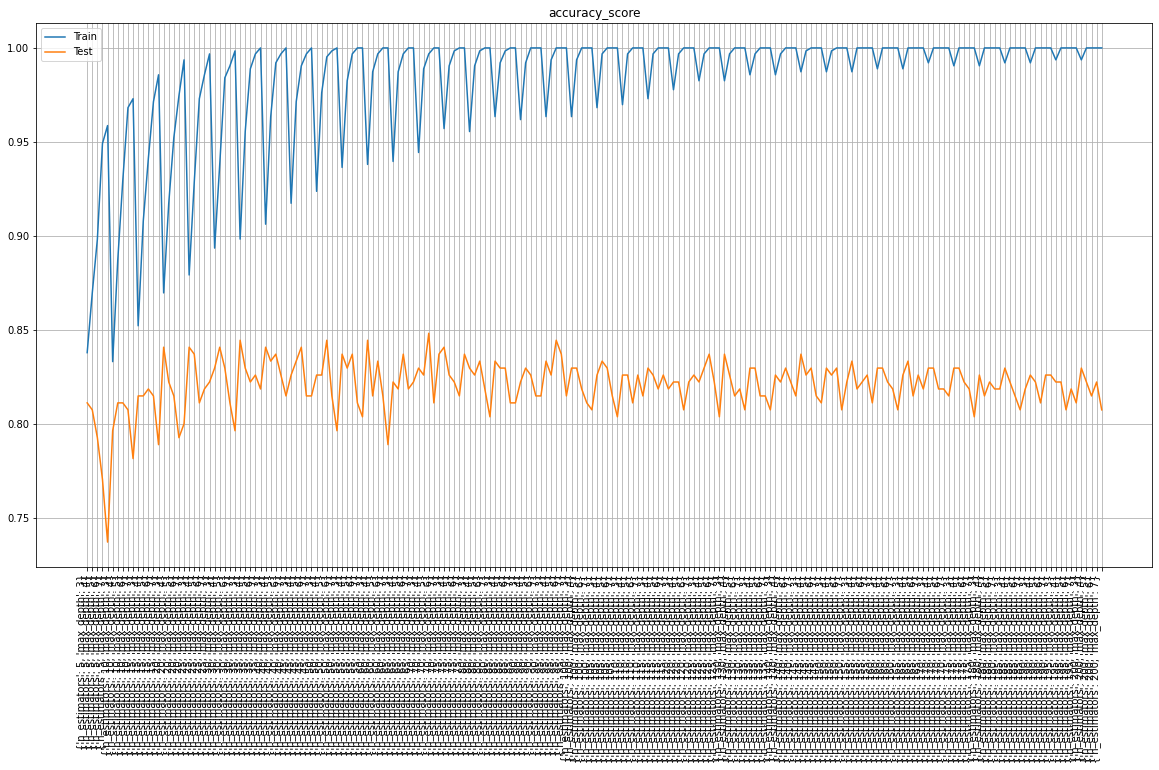

{'f1_score': 0.8619528619528619, 'accuracy_score': 0.8481481481481481, 'precision_score': 0.8258064516129032, 'recall_score': 0.9014084507042254} {'n_estimators': 70, 'max_depth': 5}


In [5]:
gb_params = [{'n_estimators': n, 'max_depth': d} for n, d in product(np.arange(5, 201, 5), np.arange(3, 8))]
gb_model, gb_result, gb_best_score, gb_best_params = optimize(df, test_size, model_constructor=GradientBoostingClassifier, param_list=gb_params, eval_metric='accuracy_score')
print(gb_best_score, gb_best_params)

                 linear  random_forest  gradient_boost
f1_score          85.90          85.44           86.20
accuracy_score    84.07          83.33           84.81
precision_score   82.91          84.08           82.58
recall_score      89.12          86.84           90.14


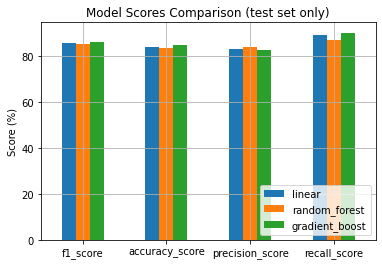

In [30]:
performance_df = pd.DataFrame([linear_best_score, rf_best_score, gb_best_score], index=['linear', 'random_forest', 'gradient_boost']).T
print((performance_df * 100).round(decimals=2))
(performance_df * 100).plot.bar()
plt.xticks(rotation=0)
plt.grid('on')
plt.ylabel('Score (%)')
plt.title('Model Scores Comparison (test set only)')
plt.legend(loc=4)
plt.savefig('data/results/model_scores.png')

In [23]:
importances = pd.DataFrame(index=df.drop('target', axis=1).columns, data=zip(rf_model.feature_importances_, gb_model.feature_importances_, linear_model.coef_.reshape(-1)), columns=['rf_importance', 'gb_importance', 'linear_coef'])

In [28]:
importances.sort_values('gb_importance', ascending=False)

with open('data/results/key_indicators.md', 'w') as out:
    out.write(importances.sort_values('gb_importance', ascending=False).to_markdown(tablefmt='github'))